# Fama and French Factor Model: Understanding the Factors #

In [1]:
# Import Libraries

# Data Management
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from config import get_tickers
from data_downloader import get_market_data
from portfolios_helper import calculate_analytics

On their website (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html), Eugene Fama and Kenneth French share the premiums of the factor model they developed several years ago. While you can simply download them, we want to show you how to approximate those premiums using free data. :)

In [2]:
# Check the Data from Fama and French
ff_premiums = pd.read_csv(r'..\additional_data\ff_size_n_value.csv')
ff_premiums.set_index('date', inplace=True)
ff_premiums.index = pd.to_datetime(ff_premiums.index)
ff_premiums.columns = ['market', 'size', 'value']

ff_premiums

,market,size,value
date,,,
1999-01-04,-0.0018,0.0014,0.0045
1999-01-05,0.0110,-0.0074,-0.0007
1999-01-06,0.0211,-0.0058,-0.0059
1999-01-07,-0.0007,0.0050,-0.0030
1999-01-08,0.0045,0.0009,0.0027
...,...,...,...
2024-12-24,0.0111,-0.0009,-0.0006
2024-12-26,0.0001,0.0104,-0.0019
2024-12-27,-0.0117,-0.0065,0.0057


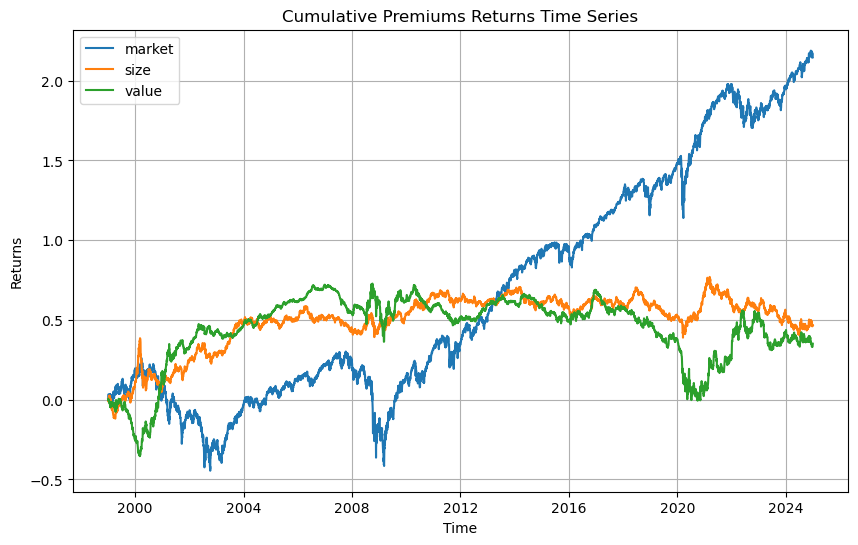

In [3]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(ff_premiums.cumsum(), label=ff_premiums.columns, alpha=1)

# Config
plt.title('Cumulative Premiums Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

### Approximate Size and Value using ETFs ###

In [8]:
# Vanguard Created 9 Portfolio Categorizing by Size and Value
categories_dict = {
    "VTV": "largecap_value",
    "VOE": "midcap_value",
    "VBR": "smallcap_value",
    "VV": "largecap_blend",
    "VO": "midcap_blend",
    "VB": "smallcap_blend",
    "VUG": "largecap_growth",
    "VOT": "midcap_growth",
    "VBK": "smallcap_growth"
}

# ":)"

In [9]:
# Tickers
tickers = get_tickers(mod="5.1")

tickers

['VTV', 'VOE', 'VBR', 'VV', 'VO', 'VB', 'VUG', 'VOT', 'VBK']

In [16]:
# Import data
etfs_returns = pd.DataFrame()

for ticker in tickers:
    df = get_market_data(
        ticker=ticker, 
        start_date='2007-01-01', 
        end_date='2025-01-01', 
        returns=True
    )
    
    returns = df['returns'].rename(ticker)
    
    etfs_returns = pd.concat([etfs_returns, returns], axis=1)

etfs_returns = etfs_returns.rename(columns=categories_dict)

In [17]:
etfs_returns

,largecap_value,midcap_value,smallcap_value,largecap_blend,midcap_blend,smallcap_blend,largecap_growth,midcap_growth,smallcap_growth
2007-01-04 00:00:00,-0.003092,0.000530,-0.000281,0.003656,-0.001103,0.001465,0.006547,0.003978,0.004747
2007-01-05 00:00:00,-0.007698,-0.008337,-0.018836,-0.006366,-0.006231,-0.016537,-0.006892,-0.006336,-0.014464
2007-01-08 00:00:00,0.003560,-0.000356,0.002142,0.001436,0.000694,0.003567,0.005002,0.005614,0.003867
2007-01-09 00:00:00,-0.001037,0.002314,0.003276,0.001275,0.002772,0.002815,-0.000172,0.001985,0.002159
2007-01-10 00:00:00,-0.002226,0.003017,0.000426,0.001432,0.006623,0.000148,0.005834,0.005930,0.001078
...,...,...,...,...,...,...,...,...,...
2024-12-24 00:00:00,0.008324,0.007730,0.007419,0.011002,0.008548,0.008316,0.013392,0.010388,0.009873
2024-12-26 00:00:00,0.002216,0.001588,0.003838,0.000289,0.000186,0.004336,-0.001550,-0.001685,0.005300
2024-12-27 00:00:00,-0.005900,-0.006858,-0.009900,-0.010743,-0.008583,-0.011619,-0.014438,-0.011956,-0.014891
2024-12-30 00:00:00,-0.010188,-0.008515,-0.006958,-0.012041,-0.009982,-0.008543,-0.012643,-0.010335,-0.009969


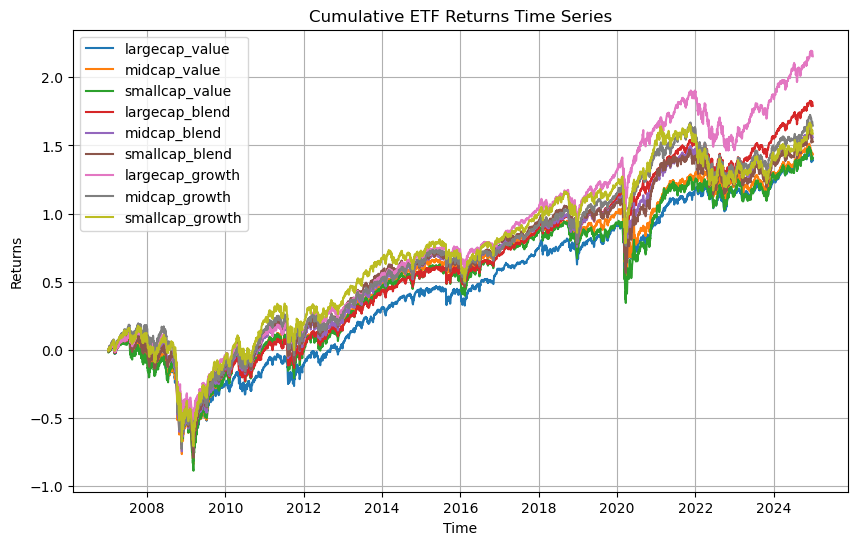

In [18]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(etfs_returns.cumsum(), label=etfs_returns.columns, alpha=1)

# Config
plt.title('Cumulative ETF Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [20]:
# Analytics Table
analytics_table = calculate_analytics(etfs_returns)

analytics_table.sort_values(by = 'Sharpe Ratio', ascending = False)

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
largecap_growth,11.984325,20.978996,0.571254,-1.0,-2.064596
largecap_blend,9.964021,19.798020,0.503284,-1.0,-1.895134
midcap_growth,9.155871,22.855659,0.400595,-1.0,-2.302367
midcap_blend,8.671134,21.805512,0.397658,-1.0,-2.138039
largecap_value,7.729635,19.947068,0.387507,-1.0,-1.871146
midcap_value,7.975141,21.842352,0.365123,-1.0,-2.056234
smallcap_growth,8.827213,24.190845,0.364899,-1.0,-2.416930
smallcap_blend,8.490975,23.708845,0.358135,-1.0,-2.315451
smallcap_value,7.815480,24.262148,0.322126,-1.0,-2.318403


This does not say too much. Let us try to group the ETFs

In [26]:
# Size DataFrame
size_df = pd.DataFrame(index = etfs_returns.index)
size_df['large'] = etfs_returns[['largecap_value', 'largecap_blend', 'largecap_growth']].mean(axis=1)
size_df['mid'] = etfs_returns[['midcap_value', 'midcap_blend', 'midcap_growth']].mean(axis=1)
size_df['small'] = etfs_returns[['smallcap_value', 'smallcap_blend', 'smallcap_growth']].mean(axis=1)

In [27]:
# Value DataFrame
value_df = pd.DataFrame(index = etfs_returns.index)
value_df['value'] = etfs_returns[['largecap_value', 'midcap_value', 'smallcap_value']].mean(axis=1)
value_df['blend'] = etfs_returns[['largecap_blend', 'midcap_blend', 'smallcap_blend']].mean(axis=1)
value_df['growth'] = etfs_returns[['largecap_growth', 'midcap_growth', 'smallcap_growth']].mean(axis=1)

In [28]:
# Analytics Table
size_analytics_table = calculate_analytics(size_df)

size_analytics_table.sort_values(by = 'Sharpe Ratio', ascending = False)

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
large,9.892660,19.746865,0.500974,-1.0,-1.895511
mid,8.600715,21.792105,0.394671,-1.0,-2.096815
small,8.377889,23.749861,0.352755,-1.0,-2.303405


In [29]:
# Analytics Table
value_analytics_table = calculate_analytics(value_df)

value_analytics_table.sort_values(by = 'Sharpe Ratio', ascending = False)

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
growth,9.989136,22.237667,0.449199,-1.0,-2.224913
blend,9.042043,21.449905,0.421542,-1.0,-2.083493
value,7.840085,21.685971,0.361528,-1.0,-2.090501


### Calculate the Premiums ###

In [38]:
# Calculate the approximation of the SMB prime
SMB = 1/3*(etfs_returns['smallcap_value'] + etfs_returns['smallcap_blend'] + etfs_returns['smallcap_growth']) - 1/3*(etfs_returns['largecap_value'] + etfs_returns['largecap_blend'] + etfs_returns['largecap_growth'])

In [39]:
# Calculate the approximation of the HML prime
HML = 1/2*(etfs_returns['largecap_value'] + etfs_returns['smallcap_value']) - 1/2*(etfs_returns['largecap_growth'] + etfs_returns['smallcap_growth'])

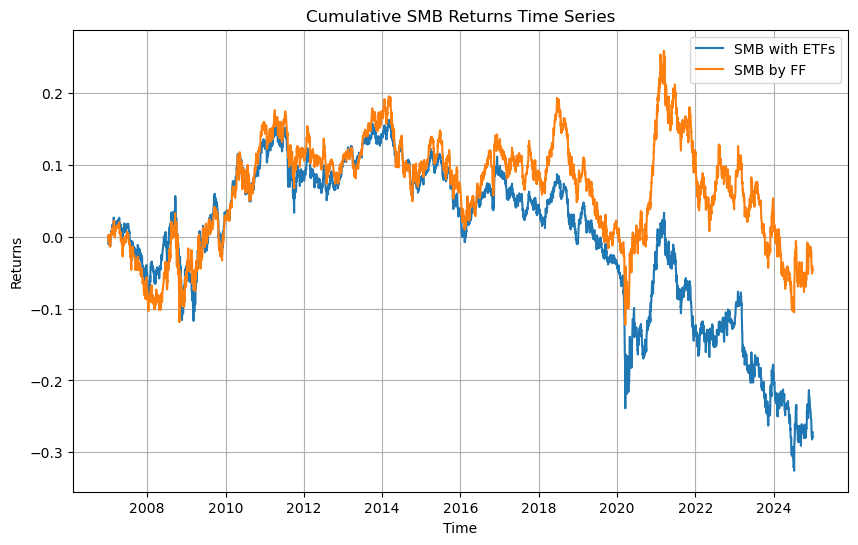

In [40]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(SMB.cumsum(), label='SMB with ETFs', alpha=1)
plt.plot(ff_premiums['size'].loc['2007':].cumsum(), label='SMB by FF', alpha=1)

# Config
plt.title('Cumulative SMB Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

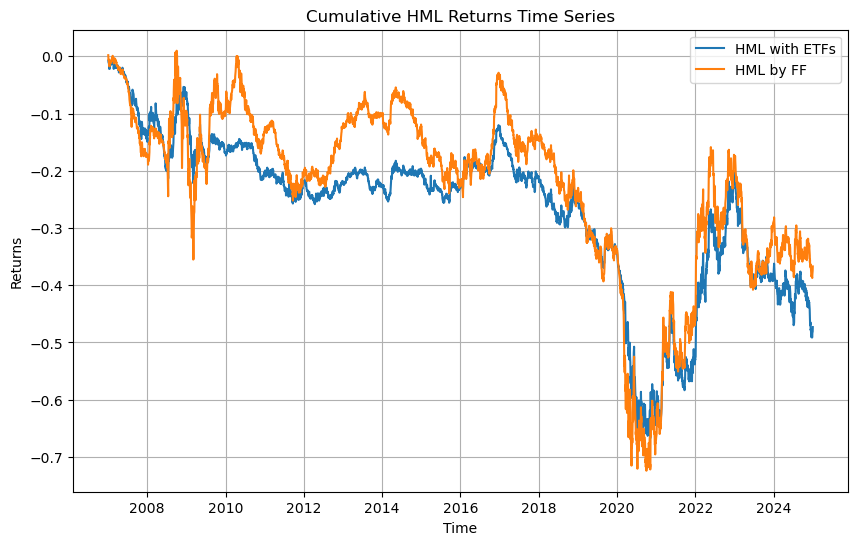

In [41]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(HML.cumsum(), label='HML with ETFs', alpha=1)
plt.plot(ff_premiums['value'].loc['2007':].cumsum(), label='HML by FF', alpha=1)

# Config
plt.title('Cumulative HML Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

Naturally, the differences between both sets of premiums can be explained by the universe used in their construction, but that is something we have to tolerate. If we don’t have access to market capitalization and fundamental data, we won’t be able to develop a factor model. Fortunately, there is a way to approximate these premiums using alternative data.